#### Adamantios Zaras AM: 06
#### Panagiotis Souranis AM: 17

# Description

In this part of the project, we created a bag of sentences for each document and worked with the most frequent class.
We transformed the problem, using the K-medoids approach, following the steps below:
1. Create a distance matrix of the bags, using the Hausdorff distance between each pair of documents.
2. Use the distance matrix, in order to cluster the bags, using the K-Medoids algorithm. Search for the number of clusters which gives the highest silhouette score for the documents.
3. Calculate the distance of each document from the resulting medoids and keep them as new features.

After the transformation of the problem, we searched for classifiers and hyperparameters, using the new dataset.  
Finally, we chose the classifier and the hyperparameters and used them in order to present the final results.

# Preparation

In [0]:
import re
import warnings
from itertools import combinations

import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.stats as sp
from keras.preprocessing.sequence import pad_sequences
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import directed_hausdorff as hausdorff_distance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from k_medoids import *
from utils import hyperparameters_search
warnings.filterwarnings("ignore")

## Prepare Dataset

Create a dataframe which contains a bag for each sentence and pair them with an id of the document that they belong to.  
Add the labels too.

In [0]:
def create_bags_of_sentences(documents_path: str, labels_path: str) -> pd.DataFrame:
    """
    Creates a bag of sentences.

    :param documents_path: the path to the documents.
    :param labels_path: the path to the labels.
    :return: Pandas Dataframe containing the bag of sentences.
    """
    # Get the most frequent class only.
    labels = pd.read_csv(labels_path, header=None)
    labels = labels[0].map(lambda x: np.array([int(lab) for lab in x.split()]))
    labels = np.array(labels.tolist())
    most_frequent_counts = np.sum(np.transpose(labels), axis=1)
    most_frequent_index = most_frequent_counts.argmax()
    labels = labels[:, most_frequent_index]

    # Open documents file.
    documents_file = open(documents_path, 'r')

    # Initialize counters and bag of sentences dictionary.
    document_counter = 0
    sentence_count = 0
    bag_of_sentences = {}

    for document, label in zip(documents_file, labels):
        # Parse document.
        parsed_document = re.split(r'<\d+>', document)

        for sentence in parsed_document:
            # Remove leading and trailing whitespaces.
            sentence = sentence.strip()

            # If sentence is not empty.
            if sentence:
                # Store words to an array of ints, since they are just ids.
                words = np.asarray(sentence.split(" "), dtype=np.int32)
                # Add a sentence to the bag.
                bag_of_sentences[sentence_count] = (document_counter, words, label)
                sentence_count += 1

        document_counter += 1

    # Close documents file.
    documents_file.close()

    # Create dataframe of the bag.
    df = pd.DataFrame.from_dict(bag_of_sentences, orient='index',
                                columns = ['Bag', 'Sentence', 'Class'])

    return df

# Create bags of sentences for the train and test data.
train_df = create_bags_of_sentences('MLTM/Data/Delicious/train-data.dat', 
                           'MLTM/Data/Delicious/train-label.dat')
test_df = create_bags_of_sentences('MLTM/Data/Delicious/test-data.dat', 
                          'MLTM/Data/Delicious/test-label.dat')

Demonstrate data structure.

In [4]:
train_df.head()

,Bag,Sentence,Class
0,0,"[6705, 5997, 8310, 3606, 674, 8058, 5044, 4836]",1
1,0,"[4312, 5154, 8310, 4225]",1
2,1,"[1827, 1037, 8482, 483]",1
3,1,"[3567, 6172, 6172, 2892, 1362, 787, 399, 777, ...",1
4,1,"[318, 769, 4621, 3199, 1480, 6213, 971, 6890]",1


Merge the bags that belong to the same document, in order to create the training and test databags-labels pairs.

In [0]:
def create_bag_per_document(df: pd.DataFrame):
    """
    Parse a sentences dataframe 
    and get a bag of sentences for each document, with its labels.

    :param df: the dataframe.
    :return: the data and the labels.
    """
    ids, X, y = np.array(df['Bag']), np.array(df['Sentence']), np.array(df['Class'])
    un_id = np.unique(ids)
    data = []
    labels = []

    for i in range(un_id.shape[0]):
        bag = X[np.where(ids == i)]
        data.append(bag)
        label = y[np.where(ids == i)]
        labels.append(label)

    data = np.array(data)
    labels = np.array(labels)
    labels = np.array([labels[i][0] for i in range(labels.shape[0])])

    # Pad sentences for 40 words per sentence max.
    for i, sentence in enumerate(data):
      data[i] = pad_sequences(sentence, maxlen=40)

    return data, labels

# Get the bags and the labels.
train_bag, y_train = create_bag_per_document(train_df)
test_bag, y_test = create_bag_per_document(test_df)

## Transform Problem

In this section, we transform the problem, using the K-medoids approach.

#### Distance matrix.

First we calculate the distance matrix.

In [0]:
def hausdorff_symmetric(x, y):
    """Calculate symmetric hausdorff distance."""
    return max(hausdorff_distance(x, y)[0], hausdorff_distance(y, x)[0])

In [0]:
# Initialize distance matrix.
n_data = train_bag.shape[0]
distance_matrix = np.zeros((n_data, n_data))

# Calculate symmetric haussdorff distances.
for (i, x), (j, y) in combinations(enumerate(train_bag), 2):
    distance_matrix[i, j] = hausdorff_symmetric(x, y)
    distance_matrix[j, i] = distance_matrix[i, j]


#### Cluster

Then we perform Grid search in order to find a suitable number of clusters, using the silhouette metric.

In [9]:
parameters = range(3, 200, 40)
res = grid_search_cv(distance_matrix,parameters,cv=4)

Best Silhouette score found after Grid search : 0.0313
Best parameter : 3


Visualize the silhouette coefficient vs number of clusters.

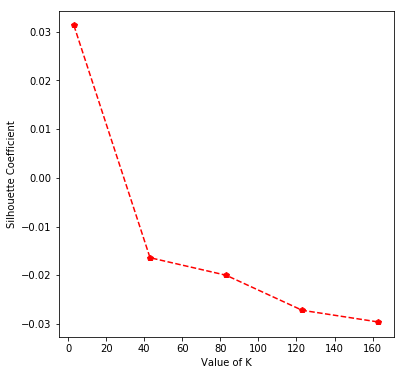

In [10]:
plt.figure(figsize=(6, 6))
plt.plot(parameters, res,'--', color='r', marker='p')
plt.xlabel('Value of K')
plt.ylabel('Silhouette Coefficient')
plt.show()

Generate the final medoids, using the best number of clusters.

In [0]:
init_medoids = sample(range(distance_matrix.shape[0]), 3)
clusterer = KMedoids(init_medoids).fit(distance_matrix)
final_medoids = train_bag[clusterer.predict(distance_matrix)]

#### Generate features.

Finally we transform the data, using the distances from the medoids as features.

In [0]:
def generate_features(data_bag, medoids) -> np.ndarray:
    """
    Generates features from a bag of instances and some medoids.

    :param data_bag: the bag of instances.
    :param medoids: the medoids features.
    :return: a numpy array containing the data with their generated features.
    """
    data_transformed = np.empty((len(data_bag), len(medoids)))

    # Generate features, using the distances from the medoids.
    for i, x in enumerate(data_bag):
        for j, medoid in enumerate(medoids):
            data_transformed[i][j] = hausdorff_symmetric(x, medoid)

    # Normalize distance features to [0, 1].
    scaler = MinMaxScaler()
    scaler.fit_transform(data_transformed)

    return data_transformed

# Transform data.
X_train_transformed = generate_features(train_bag, final_medoids)
X_test_transformed = generate_features(test_bag, final_medoids)

Demonstrate new dataset shape.

In [16]:
print('New X train data shape: {}'.format(X_train_transformed.shape))
print('New X test  data shape: {}'.format(X_test_transformed.shape))

New X train data shape: (8251, 3)
New X test  data shape: (3983, 3)


#### Visualization

Visualize our new training data with 3 features.

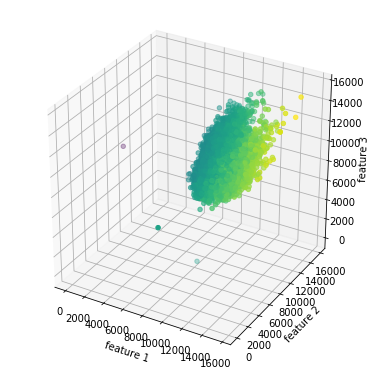

In [20]:
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig)

x = X_train_transformed[:,0]
y = X_train_transformed[:,1]
z = X_train_transformed[:,2]


ax.scatter(x, y, z,c=x, marker='o')
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

# Hyperparameters search

## Random Search

Perform a random search for the transformed dataset, using an SVM and a decision tree.

In [22]:
# Define classifiers.
classifiers = {
        'SVM': SVC(random_state=0),
        'Tree': DecisionTreeClassifier(random_state=0)}

# Create param dists.
svm_param_dist = {'C': 10 ** np.random.uniform(-3, 3, size=7000),
                  'gamma': np.random.uniform(.0001, .1, size=7000)
}
tree_param_dist = {'max_depth': scipy.stats.randint(1, 30),
                   'max_features': scipy.stats.randint(1, X_train_transformed.shape[1]),
                   'min_samples_split': scipy.stats.randint(2, X_train_transformed.shape[0] / 2),
                   'criterion': ['gini', 'entropy']
}
# Add param dists to a list.
params_list = [svm_param_dist, tree_param_dist]

# Perform random search.
for key, classifier ,params in zip(classifiers.keys(), classifiers.values(), params_list):
    hyperparameters_search(classifier, params, X_train_transformed, y_train, 'Accuracy',
                           {'Accuracy': make_scorer(accuracy_score)}, key, 
                           candidates=100, cv=5, random_search=True, verbose=5)


Εstimator : SVM
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 13.7min finished


Best parameters found for Estimator : SVM
{'gamma': 0.09032598172924863, 'C': 0.6662618489707326}

Best score found for Accuracy Score metric : 0.615

Εstimator : Tree
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    1.3s


Best parameters found for Estimator : Tree
{'criterion': 'gini', 'max_depth': 2, 'max_features': 2, 'min_samples_split': 208}

Best score found for Accuracy Score metric : 0.614


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.5s finished


## Grid Search

Perform a Grid search around the best areas that were found with the Random search above.  
Add a Multinomial Bayes too.

In [25]:
# Define classifiers.
classifiers = {
        'SVM': SVC(random_state=0),
        'Tree': DecisionTreeClassifier(random_state=0),
        'Bayes': MultinomialNB()
}

# Create parameter grids.
svm_grid = {
        'C': np.arange(0.62, 0.68, 0.01),
        'gamma': np.arange(0.08, 0.1, 0.01)
}
tree_grid = {
        'max_depth': range(1, 5),
        'max_features': range(1, 3),
        'min_samples_split': range(206, 312),
        'criterion': ['entropy', 'gini']
}
bayes_grid = {'alpha': np.arange(0, 10, 0.2)}
# Add param grids to a list.
params_list = [svm_grid, tree_grid, bayes_grid]

# Perform grid search.
for key, classifier ,params in zip(classifiers.keys(), classifiers.values(), params_list):
    hyperparameters_search(classifier, params, X_train_transformed, y_train, 'Accuracy',
                           {'Accuracy': make_scorer(accuracy_score)}, key, 
                           cv=5, random_search=False, verbose=5)


Εstimator : SVM
Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  2.6min finished


Best parameters found for Estimator : SVM
{'C': 0.62, 'gamma': 0.08}

Best score found for Accuracy Score metric : 0.615

Εstimator : Tree
Fitting 5 folds for each of 1696 candidates, totalling 8480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 3292 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 5803 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 8480 out of 8480 | elapsed:   43.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best parameters found for Estimator : Tree
{'criterion': 'entropy', 'max_depth': 2, 'max_features': 2, 'min_samples_split': 206}

Best score found for Accuracy Score metric : 0.615

Εstimator : Bayes
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found for Estimator : Bayes
{'alpha': 0.0}

Best score found for Accuracy Score metric : 0.519


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.6s finished


## Final classifier

In [0]:
# Create the best classifier found from the search.
clf = DecisionTreeClassifier(criterion='entropy', max_depth=2, max_features=2, 
                             min_samples_split=206, random_state=0)

# Results

Fit the best classifier that was found from the search procedure and predict to the transformed test data.

In [27]:
clf.fit(X_train_transformed, y_train)
y_pred = clf.predict(X_test_transformed)

print('Final Results')
print('---------------------')
print('Accuracy       {:.4f}'
      .format(accuracy_score(y_test, y_pred)))
print('Precision      {:.4f}'
      .format(precision_score(y_test, y_pred, average='macro')))
print('Recall         {:.4f}'
      .format(recall_score(y_test, y_pred, average='macro')))
print('F1             {:.4f}'
      .format(f1_score(y_test, y_pred, average='macro')))

Final Results
---------------------
Accuracy       0.6093
Precision      0.8046
Recall         0.5006
F1             0.3798


# Conclusion
The K-Medoids approach, is a powerful method which gives us the ability to handle bags of instances in an interesting way. Creating a new dataset which is able to keep information of the initial, while reducing its complexity, can bring good and fast results.  
However, the approach did not work as expected in our problem, because when a sentence is handled as an instance, an important part of the information is lost, as most of them are likely to be unique. When trying to solve a text problem, it may work better to use approaches that take words or bags of words into consideration, so that the features are directly connected with the documents.